<a href="https://colab.research.google.com/github/mnwato/captcha-recognition/blob/master/sheypoor/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Lib

In [ ]:
from matplotlib import pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras import layers
import numpy as np
import time
import os
import cv2

# Define variables

In [ ]:
use_colab = True
symbols = "0123456789"
num_digits = 4

# Download Data

In [ ]:
if use_colab == True:
    # labels2
    !gdown --i 102_85qewhU45Xwz262SzjsJ82OKIRpPT

    # chaptcha images 2999
    !gdown --i 1WrZmKh6k7d9XDOZoziomeZlozQUD-Myh

    !unzip /content/dataset.zip
    !rm /content/dataset.zip

## Load and prepair data

In [142]:
# Load labels and preprocss them
with open('labels2.txt') as f:
    labels = f.readlines()
    labels = [x.rstrip('\n') for x in labels]
    labels = np.array(labels)


# Make X,y from image and labels files
def preprocess_data():
    n_samples = len(os.listdir('/content/dataset-cat4'))
    X = np.zeros((n_samples, 42, 152, 1)) #1070*50*200
    y = np.zeros((4, n_samples, len(symbols))) #5*1070*36

    for i, pic in enumerate(os.listdir('/content/dataset-cat4')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('/content/dataset-cat4', pic), cv2.IMREAD_GRAYSCALE)
        pic_id = int(pic[:-4].replace('captcha',''))-1
        pic_target = labels[pic_id]
        if len(pic_target) < 5:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (42, 152, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((4, len(symbols)))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, Y = preprocess_data()

In [143]:
# Split and prepair data for model fitting

xtrain, ytrain = X[:2900], Y[:, :2900]
xtest, ytest = X[2900:], Y[:, 2900:]

xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((2900, 42, 152, 1), (4, 2900, 10), (99, 42, 152, 1), (4, 99, 10))

## Define model

In [8]:
def create_model():
  img_shape=(42,152,1)
  num_symbols=len(symbols)
  img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
  conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
  mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
  conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
  mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
  conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
  bn = layers.BatchNormalization()(conv3)
  mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
  # Get flattened vector and make 5 branches from it. Each branch will predict one letter
  # dns = layers.Dense(1024, activation='relu')(mp3)
  flat = layers.Flatten()(mp3)

  outs = []
  for _ in range(4):
    dens1 = layers.Dense(64, activation='relu')(flat)
    drop = layers.Dropout(0.5)(dens1)
    res = layers.Dense(num_symbols, activation='sigmoid')(drop)

    outs.append(res)

  # Create model 
  model = keras.Model(inputs=img, outputs=outs)

  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
  return model

# Model fitting

In [9]:
# Call create_model function
model = create_model()

# Fit created model
hist = model.fit(xtrain, [ytrain[0], ytrain[1], ytrain[2], ytrain[3]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Epoch 1/30
73/73 [==============================] - 17s 33ms/step - loss: 9.3122 - dense_1_loss: 2.2911 - dense_3_loss: 2.3338 - dense_5_loss: 2.3453 - dense_7_loss: 2.3420 - dense_1_accuracy: 0.1341 - dense_3_accuracy: 0.0966 - dense_5_accuracy: 0.1091 - dense_7_accuracy: 0.1004 - val_loss: 9.1797 - val_dense_1_loss: 2.2758 - val_dense_3_loss: 2.3023 - val_dense_5_loss: 2.3018 - val_dense_7_loss: 2.2998 - val_dense_1_accuracy: 0.1103 - val_dense_3_accuracy: 0.0948 - val_dense_5_accuracy: 0.1000 - val_dense_7_accuracy: 0.1310
Epoch 2/30
73/73 [==============================] - 1s 20ms/step - loss: 9.0085 - dense_1_loss: 2.1656 - dense_3_loss: 2.2868 - dense_5_loss: 2.2785 - dense_7_loss: 2.2776 - dense_1_accuracy: 0.1767 - dense_3_accuracy: 0.1177 - dense_5_accuracy: 0.1427 - dense_7_accuracy: 0.1366 - val_loss: 9.1311 - val_dense_1_loss: 2.2487 - val_dense_3_loss: 2.2963 - val_dense_5_loss: 2.2961 - val_dense_7_loss: 2.2900 - val_dense_1_accuracy: 0.1293 - val_dense_3_accuracy: 0.1155

## Save/Load Model

In [12]:
from keras.models import load_model

saveFlag = False

if saveFlag == True:
  model.save('Captcha_Recog.h5')
  print("Saved model to disk")
else:
  # load model
  model = load_model('/content/drive/MyDrive/prj/captcha_recognition/Captcha_Recog.h5')

# !cp /content/Captcha_Recog.h5 /content/drive/MyDrive/prj/captcha_recognition

## Model prediction
### Deep Learning model

In [14]:
score = model.evaluate(xtest, [ytest[0], ytest[1], ytest[2], ytest[3]])
print('Test Loss:', score[:5])
print('Test accu:', score[5:])

4/4 [==============================] - 0s 88ms/step - loss: 0.6987 - dense_1_loss: 0.1079 - dense_3_loss: 0.2450 - dense_5_loss: 0.1410 - dense_7_loss: 0.2048 - dense_1_accuracy: 0.9798 - dense_3_accuracy: 0.9596 - dense_5_accuracy: 0.9293 - dense_7_accuracy: 0.9596
Test Loss: [0.6986818909645081, 0.1078793853521347, 0.24501049518585205, 0.14103299379348755, 0.20475901663303375]
Test accu: [0.9797979593276978, 0.9595959782600403, 0.9292929172515869, 0.9595959782600403]


In [15]:
def predict(filePath):
  img = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
  if img is not None:
      img = img.astype('float') / 255.0
  else:
      print("Not detected");
  res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
  ans = np.reshape(res, (num_digits, len(symbols)))
  l_ind = []
  probs = []
  for a in ans:
      l_ind.append(np.argmax(a))
      #probs.append(np.max(a))

  capt = ''
  for l in l_ind:
      capt += symbols[l]
  return capt#, sum(probs) / 5

True captcha: [6 5 1 6]


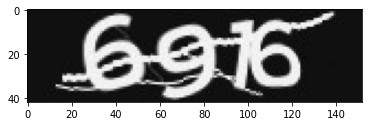

In [53]:
# Predict by xtrain, xtest

i = 1
plt.imshow(np.reshape(xtest[i], (42,152)), cmap=plt.cm.binary)
ypred = model.predict(xtest[i:i+1])
ypred = np.array(ypred)
ypred = np.reshape(ypred, (4,10))
ypred = np.argmax(ypred, axis=1)
# ypred  = [np.argmax(x) for x in ypred]
print(f'True captcha: {ypred}')

Predicted Captcha = 7496
Delay is 0.06490373611450195 sec


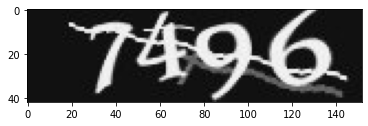

In [17]:
#Lets test an unknown captcha (by path)
#preview
%matplotlib inline 
import matplotlib.pyplot as plt

i=2500
test_img_path = f'/content/dataset/captcha{i}.jpg'

t = time.time()

img=cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

#Lets Predict By Model
print("Predicted Captcha =",predict(test_img_path))
print(f'Delay is {time.time()-t} sec')

In [173]:
from sklearn.metrics import classification_report

ypred = model.predict(xtest)
ypred = np.array(ypred)

a= ypred[0:1,:,:]
b= ypred[1:2,:,:]
c= ypred[2:3,:,:]
d= ypred[3:4,:,:]
ypred = np.concatenate((a,b,c,d), axis=1).reshape((396, 10))
# ypred = np.argmax(ypred, axis=0)

for i, elem in enumerate(ypred):
  tmp = [0]*10
  argmax = np.argmax(elem)
  tmp[argmax] = 1
  ypred[i] = tmp


a= ytest[0:1,:,:]
b= ytest[1:2,:,:]
c= ytest[2:3,:,:]
d= ytest[3:4,:,:]
ytrue = np.concatenate((a,b,c,d), axis=1).reshape((396, 10))
# ytrue = np.argmax(ytrue, axis=0)

for i, elem in enumerate(ytrue):
  tmp = [0]*10
  argmax = np.argmax(elem)
  tmp[argmax] = 1
  ytrue[i] = tmp

print(classification_report(ytrue, ypred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.92      0.96        48
           2       0.97      1.00      0.99        36
           3       0.95      0.86      0.90        44
           4       0.89      1.00      0.94        40
           5       0.89      0.94      0.92        35
           6       0.93      1.00      0.96        40
           7       0.96      0.96      0.96        46
           8       0.98      0.93      0.95        43
           9       0.97      0.93      0.95        40

   micro avg       0.95      0.95      0.95       396
   macro avg       0.95      0.95      0.95       396
weighted avg       0.95      0.95      0.95       396
 samples avg       0.95      0.95      0.95       396

